<a href="https://colab.research.google.com/github/haritsramby/Machine-Learning/blob/main/WEEK_12/W12_ML_BatchNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U mxnet-cu101==1.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install d2l==0.17.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not autograd.is_training():
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(axis=0)
            var = ((X - mean) ** 2).mean(axis=0)
        else:
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)
        X_hat = (X - mean) / np.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta 
    return Y, moving_mean, moving_var

In [4]:
class BatchNorm(nn.Block):
    def __init__(self, num_features, num_dims, **kwargs):
        super().__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = self.params.get('gamma', shape=shape, init=init.One())
        self.beta = self.params.get('beta', shape=shape, init=init.Zero())
        self.moving_mean = np.zeros(shape)
        self.moving_var = np.ones(shape)

    def forward(self, X):
        if self.moving_mean.ctx != X.ctx:
            self.moving_mean = self.moving_mean.copyto(X.ctx)
            self.moving_var = self.moving_var.copyto(X.ctx)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma.data(), self.beta.data(), self.moving_mean,
            self.moving_var, eps=1e-12, momentum=0.9)
        return Y

In [5]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        BatchNorm(6, num_dims=4),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        BatchNorm(16, num_dims=4),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        BatchNorm(120, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        BatchNorm(84, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(10))


loss 0.280, train acc 0.896, test acc 0.874
316.8 examples/sec on cpu(0)


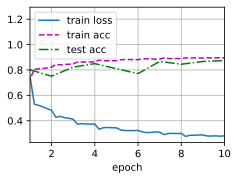

In [7]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [8]:
net[1].gamma.data().reshape(-1,), net[1].beta.data().reshape(-1,)

(array([0.85098076, 2.7776167 , 0.42564094, 4.0308156 , 0.37448213,
        4.3759394 ]),
 array([-1.4453036 ,  0.08082694,  0.5728528 ,  3.9460557 ,  0.19173059,
         2.4434562 ]))

In [9]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(10))

loss 0.266, train acc 0.903, test acc 0.873
2312.5 examples/sec on cpu(0)


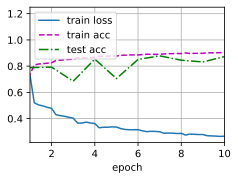

In [10]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())